<a href="https://colab.research.google.com/github/ManojKumarTiwari/DogsVsCats-Kaggle/blob/main/kaggle_dogsVcats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

# Linking Kaggle

In [1]:
# Upload your kaggle.json file before running this command
!pip install kaggle -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the data from Kaggle and unzip

In [2]:
!kaggle competitions download -c dogs-vs-cats

 99% 537M/543M [00:11<00:00, 41.8MB/s]
100% 543M/543M [00:11<00:00, 49.2MB/s]
 95% 258M/271M [00:16<00:00, 18.1MB/s]
100% 271M/271M [00:16<00:00, 17.3MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 28.5MB/s]


In [3]:
!unzip -n train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

# Install neptune and optuna

In [4]:
!pip install --quiet optuna neptune-client neptune-contrib['monitoring']

     |████████████████████████████████| 296kB 11.5MB/s 
     |████████████████████████████████| 215kB 20.8MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 163kB 19.3MB/s 
     |████████████████████████████████| 829kB 22.4MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 163kB 24.9MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 112kB 37.4MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 184kB 41.0MB/s 
     |████████████████████████████████| 276kB 20.7MB/s 
     |████████████████████████████████| 143kB 43.7MB/s 
     |████████████████████████████████| 112kB 42.2MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 133kB 40.3MB/s 
    

# Neptune Configs


## NOTE: Very important remove api from below cell

In [5]:
import neptune

neptune.init(project_qualified_name='manojtiwari/Kaggle-Dogs-vs-Cats',
             api_token='*********')

Project(manojtiwari/Kaggle-Dogs-vs-Cats)

# PARAMS

In [6]:
ROOT_DIR = 'train'

PARAMS = {'batch_size': 64,
    'target_size': (224, 224),
    'n_epochs': 5,
    'shuffle': True,
    # 'activation': 'relu',
    'dense_units': 128,
    'learning_rate': 0.001,
    'drop_out': 0.25,
    'early_stopping': 5,
    # 'n_samples': 1000,
    'base_model_trainable': False,
    'kfolds': 5
}

# Create Experiment

In [7]:
exp = neptune.create_experiment(name='resnet50v2_model',
                          description='resnet50v2_model with global_avg_pool',
                          tags=['Tensorflow', 'Binary', 'Classification'],
                          #upload_source_files=['Copy of starter_code_tf.ipynb']
                          params=PARAMS
                          )

https://ui.neptune.ai/manojtiwari/Kaggle-Dogs-vs-Cats/e/KDC-30


# Build the dataframe

In [8]:
# https://towardsdatascience.com/why-you-should-be-using-pandas-dataframes-for-keras-trainings-on-image-classification-problems-db220134cbc6
# https://www.techbeamers.com/python-glob/

import os
import pandas as pd

from glob import glob

dog_list = []
dog_class = []
cat_list = []
cat_class = []

for dog_img in glob("train/dog*"):
  dog_list.append(dog_img)
  dog_class.append(str(1))

for cat_img in glob("train/cat*"):
  cat_list.append(cat_img)
  cat_class.append(str(0))

dog_list.extend(cat_list)
dog_class.extend(cat_class)

df = pd.DataFrame(list(zip(dog_list, dog_class)), columns=['filename', 'target'])

In [9]:
df.head()

,filename,target
0,train/dog.8290.jpg,1
1,train/dog.8659.jpg,1
2,train/dog.1326.jpg,1
3,train/dog.4857.jpg,1
4,train/dog.9699.jpg,1


In [10]:
df['target'].value_counts()

0    12500
1    12500
Name: target, dtype: int64

In [11]:
df['splitted_filename'] = df['filename'].str.split('/')

# expand df.tags into its own dataframe
tags = df['splitted_filename'].apply(pd.Series)

# rename each variable is tags
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

# join the tags dataframe back to the original dataframe
df = pd.concat([df[:], tags[:]], axis=1)

df.drop(['filename', 'splitted_filename', 'tag_0'], axis=1, inplace=True)

df.rename(columns={'tag_1': 'filename'}, inplace=True)

In [12]:
df.head()

,target,filename
0,1,dog.8290.jpg
1,1,dog.8659.jpg
2,1,dog.1326.jpg
3,1,dog.4857.jpg
4,1,dog.9699.jpg


In [13]:
df.tail()

,target,filename
24995,0,cat.3950.jpg
24996,0,cat.2813.jpg
24997,0,cat.8355.jpg
24998,0,cat.9242.jpg
24999,0,cat.1544.jpg


In [14]:
df['target'].value_counts()

0    12500
1    12500
Name: target, dtype: int64

# Data versioning

In [15]:
class_names = ['Dog', 'Cat']
exp.set_property('class_names', class_names)

Experiment(KDC-30)

# Visualize the dataset

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
import numpy as np
import os


def viewRandomImage(X):
  random_index = randint(1, len(X))
  img = mpimg.imread(os.path.join(ROOT_DIR,X['filename'].values[random_index]))
  print('shape of the image: ',img.shape) # width, height, channel
  print('max value in the image: ',np.max(img))
  print('min value in the image: ', np.min(img))
  plt.title(X['target'].values[random_index])
  plt.imshow(img)
  plt.axis(False)
  exp.log_image('random_image', plt.gcf())
  return img

def viewRandomImages(X):
  for i in range(9):
    random_index = randint(1, len(X))
    img = mpimg.imread(os.path.join(ROOT_DIR,X['filename'].values[random_index]))
    # plt.figure(figsize=(7,7))
    plt.subplot(3,3,i+1)
    # #print('shape of the image: ',img.shape) # height, width, channel
    # print('max value in the image: ',np.max(img))
    # print('min value in the image: ', np.min(img))
    plt.title(X['target'].values[random_index])
    # plt.xlabel(img.shape[0])
    # plt.ylabel(img.shape[1])
    plt.imshow(img)
    # plt.axis(False)
    exp.log_image('random_image', plt.gcf())
plt.show()

shape of the image:  (171, 318, 3)
max value in the image:  255
min value in the image:  0


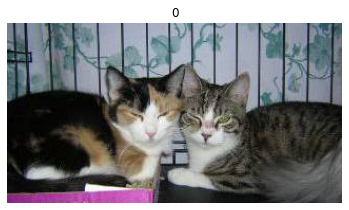

In [17]:
img = viewRandomImage(df)

# Split the dataset

In [18]:
from sklearn.model_selection import StratifiedKFold

df['kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)
kf = StratifiedKFold(PARAMS['kfolds'])

for fold, (train_idx, val_idx) in enumerate(kf.split(X=df, y=df['target'].values)):
    print(len(train_idx), len(val_idx))
    print(fold)
    df.loc[val_idx, 'kfold'] = fold

20000 5000
0
20000 5000
1
20000 5000
2
20000 5000
3
20000 5000
4


In [19]:
df['kfold'].value_counts()

4    5000
3    5000
2    5000
1    5000
0    5000
Name: kfold, dtype: int64

In [20]:
df.head()

,target,filename,kfold
0,1,dog.568.jpg,0
1,0,cat.3533.jpg,0
2,0,cat.2758.jpg,0
3,1,dog.3112.jpg,0
4,0,cat.4776.jpg,0


In [21]:
df[(df['kfold']!=1) & (df['kfold']!=PARAMS['kfolds']-1)]['kfold'].value_counts()

3    5000
2    5000
0    5000
Name: kfold, dtype: int64

In [22]:
df.to_csv('data_with_folds.csv', index=False)

# Define callbacks

In [23]:
import numpy as np

def log_data(logs, neptune):
  neptune.log_metric('epoch_accuracy', logs['accuracy'])
  neptune.log_metric('epoch_loss', logs['loss'])
  neptune.log_metric('epoch_val_accuracy', logs['val_accuracy'])
  neptune.log_metric('epoch_val_loss', logs['val_loss'])

def lr_scheduler(epoch, neptune, learning_rate):
  if epoch < 5:
    new_lr = learning_rate
  else:
    new_lr = learning_rate * np.exp(0.05 * (20-epoch))

  neptune.log_metric('learning_rate', new_lr)
  return new_lr

In [24]:
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, LearningRateScheduler
from functools import partial

neptune_logs_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: log_data(logs, exp))

early_stopping_cb = EarlyStopping(monitor='accuracy',
                                  patience=PARAMS['early_stopping'],
                                  restore_best_weights=True)

learning_rate_scheduler_cb = LearningRateScheduler(partial(lr_scheduler, 
                                                           neptune=exp, 
                                                           learning_rate=PARAMS['learning_rate']
                                                           ))

# Modelling

In [25]:
# taken from below link
# https://towardsdatascience.com/why-you-should-be-using-pandas-dataframes-for-keras-trainings-on-image-classification-problems-db220134cbc6
# https://medium.datadriveninvestor.com/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer, Dropout, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.activations import relu, softmax, sigmoid
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler,TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2
from tensorflow.keras import Model

      
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, LearningRateScheduler
from functools import partial
import neptunecontrib.monitoring.optuna as opt_utils

# image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os
import time
import gc

# set the seed
tf.random.set_seed(42)
np.random.seed(42)

# import optuna

X_test = df[df['kfold']==PARAMS['kfolds']-1]
print('X_test shape: ', X_test.shape)

test_gen = ImageDataGenerator(rescale=1/255.)

test_data = test_gen.flow_from_dataframe(
    dataframe = X_test,
    directory = ROOT_DIR,
    x_col = 'filename',
    y_col = 'target',
    batch_size = PARAMS['batch_size'],
    target_size = PARAMS['target_size'],
    class_mode = 'binary', # binary
    seed = 42,
)



# def objective(trail):

  # scores = []

for i in range(1):

  print('FOLD: ', i)


  X_train = df[(df['kfold']!=i) & (df['kfold']!=PARAMS['kfolds']-1)]
  print('X_train shape: ', X_train.shape)
  X_valid = df[df['kfold']==i]
  print('X_valid shape: ', X_valid.shape)

  # Preprocess the data
  train_gen = ImageDataGenerator(rescale=1/255.)
  valid_gen = ImageDataGenerator(rescale=1/255.)

  # import data from dataframe and turn it into batches
  train_data = train_gen.flow_from_dataframe(
      dataframe = X_train,
      directory = ROOT_DIR,
      x_col = 'filename',
      y_col = 'target',
      batch_size = PARAMS['batch_size'],
      target_size = PARAMS['target_size'],
      class_mode = 'binary', # binary
      seed = 42,
      shuffle=PARAMS['shuffle']
  )

  valid_data = valid_gen.flow_from_dataframe(
      dataframe = X_valid,
      directory = ROOT_DIR,
      x_col = 'filename',
      y_col = 'target',
      batch_size = PARAMS['batch_size'],
      target_size = PARAMS['target_size'],
      class_mode = 'binary', # binary
      seed = 42,
  )

  
  images, labels = train_data.next()
  print(images[1])

  print(train_data.class_indices)


  # Define parameters for the experiment
  # NOTE: Each run is treated as an experiment

  # model_params = {
  #     # 'no_of_conv_maxpool_layers': trail.suggest_int('number_of_conv_maxpool_layers', 3, 5),
  #     # 'conv2d_filters': trail.suggest_int('number_of_conv_maxpool_layers', 32, 64),
  #     # 'kernel_size': trail.suggest_categorical('kernel_size', [3, 5]),
  #     # 'strides':trail.suggest_categorical('strides', [1, 2]),
  #     # 'dense_units': trail.suggest_int('number_of_dense_units', 100, 200, 20)
  #     'learning_rate':trail.suggest_loguniform('learning_rate', 1e-3, 1)
  # }

  # # create the model
  # model = Sequential()
  # model.add(Conv2D(30, 5, activation=relu, input_shape=(224, 224, 3)))
  # model.add(MaxPool2D(2))
  # model.add(Conv2D(20, 5, activation=relu))
  # model.add(MaxPool2D(2))
  # model.add(Conv2D(10, 5, activation=relu))
  # model.add(MaxPool2D(2))
  # # # model.add(InputLayer(shape=(224, 224, 3)))
  # # for conv_maxpool_layers in range(model_params['no_of_conv_maxpool_layers']):
  # #   model.add(Conv2D(filters=model_params['conv2d_filters'],
  # #                    kernel_size=model_params['kernel_size'],
  # #                    # strides=model_params['strides'],
  # #                    activation=relu,
  # #                    input_shape=(224, 224, 3)
  # #                    ))
  # #   model.add(MaxPool2D(2))
  # model.add(Flatten())
  # model.add(Dense(PARAMS['dense_units'], activation=relu))
  # model.add(Dropout(PARAMS['drop_out'])),
  # model.add(Dense(1, activation = sigmoid))


  data_augmentation_block = Sequential([preprocessing.RandomFlip('horizontal'),
                            preprocessing.RandomZoom(0.2),
                            preprocessing.RandomHeight(0.2),
                            preprocessing.RandomWidth(0.2),
                            preprocessing.RandomRotation(0.2)
                            ], name='data_augmentation_layer')

  base_model = ResNet50V2(include_top=False)

  base_model.trainable = PARAMS['base_model_trainable']

  inputs = Input(shape=(224, 224, 3), name='input_layer')

  x = data_augmentation_block(inputs)

  x = base_model(x, training = False)

  x = GlobalAveragePooling2D()(x)

  outputs = Dense(1, activation=sigmoid, name='output_layer')(x)

  model = Model(inputs, outputs)

  # # define cnn model
  # def define_model():
  #   model = Sequential()
  #   model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
  #   model.add(MaxPool2D((2, 2)))
  #   model.add(Flatten())
  #   model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  #   model.add(Dense(1, activation='sigmoid'))
  #   # compile model
  #   opt = SGD(lr=0.001, momentum=0.9)
  #   model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  #   return model

  # compile the model
  model.compile(optimizer = Adam(), 
            loss= binary_crossentropy, 
            metrics = ['accuracy'])

  # model = define_model()

  model.summary(print_fn=lambda x: neptune.log_text('model summary', x))

  history = model.fit(
  train_data,
  epochs = PARAMS['n_epochs'],
  steps_per_epoch = len(train_data),
  validation_data = valid_data,
  validation_steps = len(valid_data),
  callbacks=[neptune_logs_cb, early_stopping_cb, learning_rate_scheduler_cb]
  )

  print(model.evaluate(test_data))

    #     score = model.evaluate(test_data)
    #     scores.append(score[1])
    # return np.max(scores)

X_test shape:  (5000, 3)
Found 5000 validated image filenames belonging to 2 classes.
FOLD:  0
X_train shape:  (15000, 3)
X_valid shape:  (5000, 3)
Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
[[[0.42352945 0.5176471  0.4666667 ]
  [0.4039216  0.49803925 0.44705886]
  [0.38823533 0.48235297 0.43137258]
  ...
  [0.5176471  0.5882353  0.48627454]
  [0.52156866 0.5921569  0.4901961 ]
  [0.5176471  0.5882353  0.48627454]]

 [[0.4039216  0.4901961  0.4431373 ]
  [0.39607847 0.48235297 0.43529415]
  [0.40000004 0.48627454 0.43921572]
  ...
  [0.5058824  0.5686275  0.4666667 ]
  [0.5176471  0.5803922  0.4784314 ]
  [0.52156866 0.58431375 0.48235297]]

 [[0.38823533 0.47450984 0.427451  ]
  [0.4039216  0.4901961  0.4431373 ]
  [0.42352945 0.50980395 0.46274513]
  ...
  [0.5058824  0.56078434 0.46274513]
  [0.5176471  0.57254905 0.47450984]
  [0.5294118  0.58431375 0.48627454]]

 ...

 [[0.37254903 0.42352945 0.396078

# Evaluate

In [26]:
model.evaluate(test_data)

79/79 [==============================] - 29s 360ms/step - loss: 0.0332 - accuracy: 0.9882


[0.033165257424116135, 0.9882000088691711]

# Create neptune callback

In [27]:
# import neptunecontrib.monitoring.optuna as opt_utils

# neptune_callback = opt_utils.NeptuneCallback(log_study=True, log_charts=True)

# Run optuna hyperparameter tuning

In [28]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10, timeout=60 * 300, callbacks=[neptune_callback])

# # Log Optuna charts and study object after the sweep is complete
# opt_utils.log_study_info(study)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# Save the model

In [33]:
model.save('resnet50v2_model')

INFO:tensorflow:Assets written to: resnet50v2_model/assets


# Download the model

In [57]:
!zip -r /content/resnet50v2_model.zip /content/resnet50v2_model

  adding: content/resnet50v2_model/ (stored 0%)
  adding: content/resnet50v2_model/variables/ (stored 0%)
  adding: content/resnet50v2_model/variables/variables.index (deflated 76%)
  adding: content/resnet50v2_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/resnet50v2_model/assets/ (stored 0%)
  adding: content/resnet50v2_model/saved_model.pb (deflated 92%)


In [58]:
from google.colab import files
files.download('resnet50v2_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Stop logging to neptune

In [32]:
neptune.stop()

# Prediction

In [3]:
!unzip -n /content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [28]:
import os
import pandas as pd

file_name = []
for file in os.listdir('test1'):
  file_name.append(file)

df_test = pd.DataFrame(file_name, columns=['file_name'])

In [29]:
df_test.head()

,file_name
0,9201.jpg
1,11049.jpg
2,7888.jpg
3,1964.jpg
4,7777.jpg


In [30]:
df_test['splitted_filename'] = df_test['file_name'].str.split('.')

# expand df.tags into its own dataframe
tags = df_test['splitted_filename'].apply(pd.Series)

# rename each variable is tags
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

# join the tags dataframe back to the original dataframe
df_test = pd.concat([df_test[:], tags[:]], axis=1)

df_test.drop(['splitted_filename', 'tag_1'], axis=1, inplace=True)

df_test.rename(columns={'tag_0': 'id'}, inplace=True)

df_test['id'] = df_test['id'].astype(int)
df_test = df_test.sort_values(by='id').reset_index(drop=True)

In [31]:
df_test.head()

,file_name,id
0,1.jpg,1
1,2.jpg,2
2,3.jpg,3
3,4.jpg,4
4,5.jpg,5


In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def viewImage(file_name):
  img = mpimg.imread(file_name)
  plt.imshow(img)
  return img

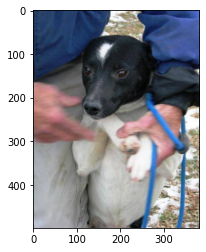

In [33]:
ROOT_TEST_DIR = 'test1'

img = viewImage(os.path.join(ROOT_TEST_DIR, '1.jpg'))

In [21]:
!unzip -n /content/resnet50v2_model.zip

Archive:  /content/resnet50v2_model.zip
   creating: content/resnet50v2_model/
   creating: content/resnet50v2_model/variables/
  inflating: content/resnet50v2_model/variables/variables.index  
  inflating: content/resnet50v2_model/variables/variables.data-00000-of-00001  
   creating: content/resnet50v2_model/assets/
  inflating: content/resnet50v2_model/saved_model.pb  


In [41]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

model = load_model('/content/content/resnet50v2_model')

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	return img

# load an image and predict the class
def predict_example(file_name):
	# load the image
	img = load_image(file_name)
	# load model
	model = model
	# predict the class
	result = model.predict(img)
	print(result)
 
 # load an image and predict the class
def predict_examples(df):
  # test_idx = df['tag_0']
  # predictions = None
  # model = load_model('resnet50v2_model')
  model = model

  idxs = []
  y_preds = []
  for idx, img in enumerate(df['file_name'].tolist()):
    print(img, idx)
    # load the image
    img = load_image(os.path.join('test1',img))
    # load model
    # model = load_model('resnet50v2_model')
    # predict the class
    result = model.predict(img)
    y_preds.append(result[0])
    idxs.append(idx+1)

  sub_df = pd.DataFrame(np.column_stack((idxs, y_preds)), columns=['id', 'label'])
  return sub_df

  # return y_preds

[[0.]]


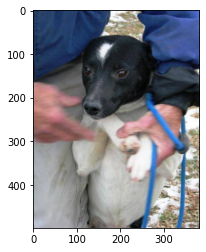

In [35]:
img = viewImage(os.path.join(ROOT_TEST_DIR, '1.jpg'))
predict_example(os.path.join(ROOT_TEST_DIR, '1.jpg'))

In [36]:
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our modle
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [37]:
img = load_and_prep_image(os.path.join(ROOT_TEST_DIR, '1.jpg'))

In [39]:
# Add an extra axis
print(f"Shape before new dimension: {img.shape}")
img = tf.expand_dims(img, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {img.shape}")
img

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.14021358, 0.25393906, 0.37158617],
         [0.13306865, 0.24679415, 0.37228432],
         [0.14897941, 0.259755  , 0.39999482],
         ...,
         [0.3297515 , 0.4673063 , 0.8436446 ],
         [0.27801168, 0.42290828, 0.7803753 ],
         [0.18470447, 0.33431697, 0.6717734 ]],

        [[0.15865721, 0.27238274, 0.3900298 ],
         [0.14181547, 0.25554097, 0.3810312 ],
         [0.12273999, 0.23351556, 0.37375543],
         ...,
         [0.33185884, 0.45413104, 0.83490866],
         [0.27793387, 0.40858865, 0.77933705],
         [0.18176652, 0.32240796, 0.6700369 ]],

        [[0.13902669, 0.25275216, 0.3703992 ],
         [0.10609762, 0.21982309, 0.3453133 ],
         [0.12289562, 0.23367116, 0.373911  ],
         ...,
         [0.34279218, 0.45198372, 0.84042317],
         [0.29389152, 0.40369543, 0.7844904 ],
         [0.19799551, 0.31902143, 0.6789043 ]],

        ...,

        [[0.67360216, 0.70105314, 

In [44]:
model.predict(img)[0][0]

0.9979006

In [49]:
import numpy as np

def pred_and_plot(df):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """

  model = load_model('/content/content/resnet50v2_model')

  idxs = []
  y_preds = []
  for idx, img in enumerate(df['file_name'].tolist()):
    print(img, idx)
    # Import the target image and preprocess it
    img = load_and_prep_image(os.path.join('test1',img))

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))[0][0]

    y_preds.append(pred)
    idxs.append(idx+1)

  sub_df = pd.DataFrame(np.column_stack((idxs, y_preds)), columns=['id', 'label'])
  return sub_df

In [50]:
sub_df = pred_and_plot(df_test)

Streaming output truncated to the last 5000 lines.
7501.jpg 7500
7502.jpg 7501
7503.jpg 7502
7504.jpg 7503
7505.jpg 7504
7506.jpg 7505
7507.jpg 7506
7508.jpg 7507
7509.jpg 7508
7510.jpg 7509
7511.jpg 7510
7512.jpg 7511
7513.jpg 7512
7514.jpg 7513
7515.jpg 7514
7516.jpg 7515
7517.jpg 7516
7518.jpg 7517
7519.jpg 7518
7520.jpg 7519
7521.jpg 7520
7522.jpg 7521
7523.jpg 7522
7524.jpg 7523
7525.jpg 7524
7526.jpg 7525
7527.jpg 7526
7528.jpg 7527
7529.jpg 7528
7530.jpg 7529
7531.jpg 7530
7532.jpg 7531
7533.jpg 7532
7534.jpg 7533
7535.jpg 7534
7536.jpg 7535
7537.jpg 7536
7538.jpg 7537
7539.jpg 7538
7540.jpg 7539
7541.jpg 7540
7542.jpg 7541
7543.jpg 7542
7544.jpg 7543
7545.jpg 7544
7546.jpg 7545
7547.jpg 7546
7548.jpg 7547
7549.jpg 7548
7550.jpg 7549
7551.jpg 7550
7552.jpg 7551
7553.jpg 7552
7554.jpg 7553
7555.jpg 7554
7556.jpg 7555
7557.jpg 7556
7558.jpg 7557
7559.jpg 7558
7560.jpg 7559
7561.jpg 7560
7562.jpg 7561
7563.jpg 7562
7564.jpg 7563
7565.jpg 7564
7566.jpg 7565
7567.jpg 7566
7568.jpg 75

In [52]:
sub_df.head()

,id,label
0,1.0,0.997901
1,2.0,0.999994
2,3.0,0.999973
3,4.0,0.999862
4,5.0,0.000042


In [53]:
sub_df['id'] = sub_df['id'].astype(int)

In [54]:
sub_df.head()

,id,label
0,1,0.997901
1,2,0.999994
2,3,0.999973
3,4,0.999862
4,5,0.000042


In [58]:
sub_df.to_csv('submission1.csv', index=False)

In [59]:
from google.colab import files
files.download('submission1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>